## Initialize the Env

In [3]:
%load_ext autoreload
%autoreload 2

import jax
from brax import envs
from rodent import RodentMultiClipTracking, RodentTracking
import pickle
from preprocessing.mjx_preprocess import process_clip_to_train
import pickle
import os
from matplotlib import pyplot as plt
import numpy as np
from jax import numpy as jp

try:
    n_devices = jax.device_count(backend="gpu")
    os.environ["XLA_FLAGS"] = (
        "--xla_gpu_enable_triton_softmax_fusion=true " "--xla_gpu_triton_gemm_any=True "
    )
    print(f"Using {n_devices} GPUs")
except:
    n_devices = 1
    print("Not using GPUs")

config = {
    "env_name": "multi clip",
    "algo_name": "ppo",
    "task_name": "run",
    "num_envs": 128 ,
    "num_timesteps": 5_000_000_000,
    "eval_every": 50_000_000,
    "episode_length": 200,
    "batch_size": 128 ,
    "num_minibatches": 4,
    "num_updates_per_batch": 8,
    "learning_rate": 7e-5,
    "clipping_epsilon": 0.2,
    "torque_actuators": False,
    "physics_steps_per_control_step": 5,
    "too_far_dist": 0.01,
    "bad_pose_dist": 20,
    "bad_quat_dist": 1,
    "ctrl_cost_weight": 0.02,
    "ctrl_diff_cost_weight": 0.02,
    "pos_reward_weight": 1.0,
    "quat_reward_weight": 1.0,
    "joint_reward_weight": 1.0,
    "angvel_reward_weight": 0.0,
    "bodypos_reward_weight": 0.0,
    "endeff_reward_weight": 1.0,
    "healthy_z_range": (0.0325, 0.5),
    "run_platform": "Harvard",
    "solver": "cg",
    "iterations": 12,
    "ls_iterations": 12,
}

envs.register_environment("single clip", RodentTracking)
envs.register_environment("multi clip", RodentMultiClipTracking)

Not using GPUs


In [4]:
clip_id = -1
with open("./clips/all_snips.p", "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)

/var/folders/f1/rpl_f5_j46q42cptb030mpnr0000gn/T/ipykernel_34290/315379843.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  reference_clip = pickle.load(file)
/var/folders/f1/rpl_f5_j46q42cptb030mpnr0000gn/T/ipykernel_34290/315379843.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  reference_clip = pickle.load(file)
/var/folders/f1/rpl_f5_j46q42cptb030mpnr0000gn/T/ipykernel_34290/315379843.py:4: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  reference_clip = pickle.load(file)
/var/folders/f1/rpl_f5_j46q42cptb030mpnr0000gn/T/ipykernel_34290/315379843.py:4: Deprecatio

In [5]:
# instantiate the environment
env = envs.get_environment(
    config["env_name"],
    reference_clip=reference_clip,
    torque_actuators=config["torque_actuators"],
    solver=config["solver"],
    iterations=config["iterations"],
    ls_iterations=config["ls_iterations"],
    too_far_dist=config["too_far_dist"],
    bad_pose_dist=config["bad_pose_dist"],
    bad_quat_dist=config["bad_quat_dist"],
    ctrl_cost_weight=config["ctrl_cost_weight"],
    ctrl_diff_cost_weight=config["ctrl_diff_cost_weight"],
    pos_reward_weight=config["pos_reward_weight"],
    quat_reward_weight=config["quat_reward_weight"],
    joint_reward_weight=config["joint_reward_weight"],
    angvel_reward_weight=config["angvel_reward_weight"],
    bodypos_reward_weight=config["bodypos_reward_weight"],
    endeff_reward_weight=config["endeff_reward_weight"],
    healthy_z_range=config["healthy_z_range"],
    physics_steps_per_control_step=config["physics_steps_per_control_step"],
)

/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:344: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  link = jax.tree_map(lambda x: x[1:].copy(), link)
/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:374: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  motion = jax.tree_map(lambda *x: np.concatenate(x), *motions)
/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:378: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  limit = jax.tree_map(lambda *x: np.concatenate(x), *limits)
/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/brax/io/mjcf.py:414: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (j

self._steps_for_cur_frame: 2.0


In [6]:
import custom_wrappers
rollout_env = custom_wrappers.EvalClipWrapperTracking(env)
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
key = jax.random.PRNGKey(0)
state = jit_reset(key)

In [7]:
import orbax.checkpoint as ocp
import masked_running_statistics
from brax.training.acme import specs
import custom_ppo_networks
import custom_losses as ppo_losses
from pathlib import Path
tracking_task_obs_size = 470
checkpoint_path = Path("0ce773e7-1d50-4475-b338-9b5f6510c56c")
key_policy, key_value = jax.random.split(jax.random.key(0))

ckptr = ocp.CompositeCheckpointHandler()
tracking_task_obs_size = 470
tracking_obs_size = (
    state.obs.shape[-1]
    - state.info["task_obs_size"]
    + tracking_task_obs_size
)

In [11]:
tracking_obs_size

Array(617, dtype=int32, weak_type=True)

In [15]:
# This will go in brax_rodent_trnaingidan.py
import utils

checkpoint_metadata = {
    "encoder_hidden_layer_sizes": list((512, 512)),
    "decoder_hidden_layer_sizes": list((512, 512)),
    "value_hidden_layer_sizes": list((512, 512)),
    "intention_latent_size": 60,
    "tracking_obs_size": int(tracking_obs_size), # 617
    "tracking_task_obs_size": int(tracking_task_obs_size), # 470
    "action_size": int(env.action_size) # 38
}

# this will be the uuid / metadata.yaml
file_path = checkpoint_path.resolve() / "metadata.yaml"
utils.save_yaml(checkpoint_metadata, file_path)

In [16]:
checkpoint_metadata

{'encoder_hidden_layer_sizes': [512, 512],
 'decoder_hidden_layer_sizes': [512, 512],
 'value_hidden_layer_sizes': [512, 512],
 'intention_latent_size': 60,
 'tracking_obs_size': 617,
 'tracking_task_obs_size': 470}

In [17]:
metadata = utils.load_yaml(file_path)

In [18]:
checkpoint_ppo_network = custom_ppo_networks.make_intention_ppo_networks(
    metadata['tracking_obs_size'],
    metadata['tracking_task_obs_size'],
    metadata['action_size'],
    preprocess_observations_fn=masked_running_statistics.normalize,
    intention_latent_size=metadata['intention_latent_size'],
    encoder_hidden_layer_sizes=metadata['encoder_hidden_layer_sizes'],
    decoder_hidden_layer_sizes=metadata['decoder_hidden_layer_sizes'],
    value_hidden_layer_sizes=metadata['value_hidden_layer_sizes'],
)
checkpoint_init_params = ppo_losses.PPONetworkParams(
    policy=checkpoint_ppo_network.policy_network.init(key_policy),
    value=checkpoint_ppo_network.value_network.init(key_value),
)
target = ocp.args.Composite(
    normalizer_params=ocp.args.StandardRestore(
        masked_running_statistics.init_state(
            specs.Array(metadata['tracking_obs_size'], jp.dtype("float32"))
        )
    ),
    params=ocp.args.StandardRestore(checkpoint_init_params),
    env_steps=ocp.args.ArrayRestore(0),
)
loaded_ckpt = ckptr.restore(
    checkpoint_path.resolve() / '84',
    args=target,
)

In [13]:
loaded_ckpt.keys()

dict_keys(['env_steps', 'normalizer_params', 'params'])

In [6]:
load_params = loaded_ckpt['params']

In [12]:
load_params.policy["params"][
                "decoder"
            ]

{'LayerNorm_0': {'bias': Array([-3.17056035e-03,  1.06089938e-04, -4.28803032e-03, -1.67639256e-02,
         -8.59909505e-03, -3.96931171e-03,  8.73345789e-03, -1.16549144e-02,
         -2.41523758e-02,  9.39790101e-04, -4.46365355e-03,  2.21185647e-02,
         -6.34479569e-03, -1.16709359e-02,  6.08912716e-03, -6.71616616e-03,
          3.02646821e-03, -1.87175665e-02, -4.12995508e-03,  4.87384340e-03,
         -1.85358967e-03, -1.17596379e-03, -7.65890582e-03,  1.52708655e-02,
         -1.29028959e-02,  9.51262284e-03,  1.54099870e-03,  1.91490557e-02,
         -7.76847871e-03,  8.39354750e-03,  2.04132628e-02,  8.86082184e-03,
         -5.71088679e-03,  1.50464373e-02,  3.89819662e-03, -4.96171135e-03,
         -1.12920254e-02,  7.98788015e-03,  4.86756349e-03,  1.20557415e-04,
         -1.06485300e-02, -1.61543749e-02, -1.33061095e-03,  7.64021883e-03,
          1.14290491e-02,  1.80439593e-03, -5.74764051e-03, -2.28233188e-02,
         -6.24738541e-03,  2.79090856e-03, -3.3674379

In [6]:
import custom_losses as ppo_losses
from brax.training.acme import running_statistics
import functools
import custom_ppo_networks
ppo_network = functools.partial(
        custom_ppo_networks.make_intention_ppo_networks,
        encoder_hidden_layer_sizes=(512, 512),
        decoder_hidden_layer_sizes=(512, 512),
        value_hidden_layer_sizes=(512, 512),
    )(
        state.obs.shape[-1],
        int(state.info["reference_obs_size"]),
        env.action_size,
        preprocess_observations_fn=running_statistics.normalize,
    )
init_params = ppo_losses.PPONetworkParams(
        policy=ppo_network.policy_network.init(jax.random.key(0)),
        value=ppo_network.value_network.init(jax.random.key(0)),
    )

In [6]:
import custom_ppo_networks

ppo_network = custom_ppo_networks.make_intention_ppo_networks(
        state.obs.shape[-1],
        state.info["reference_obs_size"],
        env.action_size,
        preprocess_observations_fn=False,
    )

In [7]:
import custom_losses as ppo_losses

init_params = ppo_losses.PPONetworkParams(
        policy=ppo_network.policy_network.init(jax.random.key(0)),
        value=ppo_network.value_network.init(jax.random.key(1)),
    )

NameError: name 'ppo_network' is not defined

In [11]:
def create_decoder_mask(params, decoder_name="decoder"):
    """Creates boolean mask were any leaves under decoder are set to False."""

    def _mask_fn(path, _):
        def f(key):
            try:
                return key.key
            except:
                return key.name
        # Check if any part of the path contains 'decoder'
        return "frozen" if decoder_name in [str(f(part)) for part in path] else "learned"

    # Create mask using tree_map_with_path
    return jax.tree_util.tree_map_with_path(lambda path, _: _mask_fn(path, _), params)


In [16]:
create_decoder_mask(init_params)

PPONetworkParams(policy={'params': {'decoder': {'LayerNorm_0': {'bias': False, 'scale': False}, 'LayerNorm_1': {'bias': False, 'scale': False}, 'hidden_0': {'bias': False, 'kernel': False}, 'hidden_1': {'bias': False, 'kernel': False}, 'hidden_2': {'bias': False, 'kernel': False}}, 'encoder': {'LayerNorm_0': {'bias': True, 'scale': True}, 'LayerNorm_1': {'bias': True, 'scale': True}, 'hidden_0': {'bias': True, 'kernel': True}, 'hidden_1': {'bias': True, 'kernel': True}}, 'latent': {'logvar': {'bias': True, 'kernel': True}, 'mean': {'bias': True, 'kernel': True}}}}, value={'params': {'hidden_0': {'bias': True, 'kernel': True}, 'hidden_1': {'bias': True, 'kernel': True}, 'hidden_2': {'bias': True, 'kernel': True}}})

In [7]:
import custom_ppo_networks 
from brax.training.acme import running_statistics

from typing import Any, Dict, Sequence, Tuple, Union, Optional

# Copy and pasted from https://github.com/google/brax/discussions/403#discussioncomment-7287194
def make_inference_fn(
    observation_size: int,
    reference_obs_size: int,
    action_size: int,
    normalize_observations: bool = False,
):
  normalize = running_statistics.normalize if normalize_observations else lambda x, y: x
  ppo_network = custom_ppo_networks.make_intention_ppo_networks(
      observation_size,
      reference_obs_size,
      action_size,
      preprocess_observations_fn=normalize,
      encoder_hidden_layer_sizes=(512,512),
      decoder_hidden_layer_sizes=(512,512),
      value_hidden_layer_sizes=(512,512)
  )
  make_policy = custom_ppo_networks.make_inference_fn(ppo_network)
  return make_policy

make_policy = make_inference_fn(
    observation_size=env.observation_size,
    reference_obs_size=state.info["reference_obs_size"],
    action_size=env.action_size,
    normalize_observations = True,
)


KeyboardInterrupt: 

In [1]:
from brax.io import model
model_path = "./58683329-0cf5-42dd-8fe0-66dc839898da-latest" # "./f89b1cdb-db57-4904-a58a-abc42539c462-latest"
params = model.load_params(model_path)

In [5]:
p = params[1]
p['params'].keys()

dict_keys(['decoder', 'encoder'])

In [9]:
import custom_networks
import custom_ppo_networks
from brax.training import networks
from brax.training.acme import running_statistics

from brax.training import types
from brax.training import distribution
from typing import Any, Callable, Sequence, Tuple

policy_fn = custom_networks.make_random_intention_policy(
    env.action_size * 2, 
    60, 
    env.observation_size, 
    state.info["task_obs_size"], 
    running_statistics.normalize, 
    (512,512)
)




In [10]:
policy = policy_fn.init(jax.random.key(0))
jit_policy_apply = jax.jit(policy_fn.apply)

In [11]:
load_params[1]['params']['decoder']

TypeError: 'PPONetworkParams' object is not subscriptable

In [12]:
policy['params']['decoder'] = load_params.policy['params']['decoder']

## Render the Clip

In [7]:
state.info["clip_idx"]

Array(0, dtype=int32, weak_type=True)

In [15]:
import mediapy as media
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
clip_idx = 0
key = jax.random.PRNGKey(0)

/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [16]:
params[0]

NameError: name 'params' is not defined

In [17]:
clip_idx = 102
# initialize the state
_, key = jax.random.split(key)
state = jit_reset(key, clip_idx)
rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 500
for i in tqdm(range(n_steps)):
  act_rng, rng = jax.random.split(key)
  
  ctrl, _ = policy_fn.apply(loaded_ckpt['normalizer_params'], policy, state.obs, act_rng)
  #Also apply a tanh to the ctrl?
  ctrl = jp.tanh(ctrl)
  state = jit_step(state, jp.split(ctrl, 2)[0])
  
  rollout.append(state.pipeline_state)
  states.append(state)

100%|██████████| 500/500 [01:20<00:00,  6.19it/s] 


In [26]:
params[1]['params']['encoder'].keys()

dict_keys(['LayerNorm_0', 'LayerNorm_1', 'fc2_logvar', 'fc2_mean', 'hidden_0', 'hidden_1'])

In [8]:
key = jax.random.split(jax.random.key(200), reference_clip.position.shape[0])
def rollout_fn(i, key):
    # initialize the state
    _, key, act_rng = jax.random.split(key, 3)
    state = jit_reset(key, i)
    qposes = state.pipeline_state.qpos
    done_step = -1
    # grab a trajectory
    n_steps = 500
    # might becasue brax does not clip the action to the xml limit in the model
    for i in range(n_steps):
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        
        qposes = jp.vstack([qposes, state.pipeline_state.qpos])
        done_step = jp.where(state.done + done_step == 0, i // 2, done_step)
    
    return qposes, done_step

rollout_vmap = jax.vmap(rollout_fn)

In [9]:
# get qposes for all 842 clips
indices = jp.arange(reference_clip.position.shape[0])
qposes, done_steps = rollout_vmap(indices, key)

/home/charles/github/Brax-Rodent-Run/Rodent_Env_Brax.py:244: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  reference_frame = jax.tree_map(
/home/charles/github/Brax-Rodent-Run/Rodent_Env_Brax.py:556: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)
/home/charles/github/Brax-Rodent-Run/Rodent_Env_Brax.py:556: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[info["clip_idx"]], self._reference_clips)
/home/charles/github/Brax-Rodent-Run/Rodent_Env_Brax.py:313: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  reference_clip = jax.tree_map(
/home

In [10]:
deterministic_qposes = np.array(qposes[:, :-1, :])[:, ::2, :]
deterministic_qposes.shape

(842, 250, 74)

In [10]:
np.save(f"all_snips_qposes_{model_path[2:]}.npy", deterministic_qposes)

In [11]:
done_steps = jp.where(done_steps == -1, 250, done_steps)
np.save(f"all_snips_done_steps_{model_path[2:]}.npy", done_steps)

In [35]:
done_steps

Array([250,  38, 250, ..., 250, 250, 250], dtype=int32, weak_type=True)

In [16]:
filtered_deterministic_qposes = deterministic_qposes[done_steps > 200]


In [17]:
filtered_deterministic_qposes.shape

(831, 250, 74)

In [34]:
np.save("filtered_deterministic_qposes.npy", filtered_deterministic_qposes)

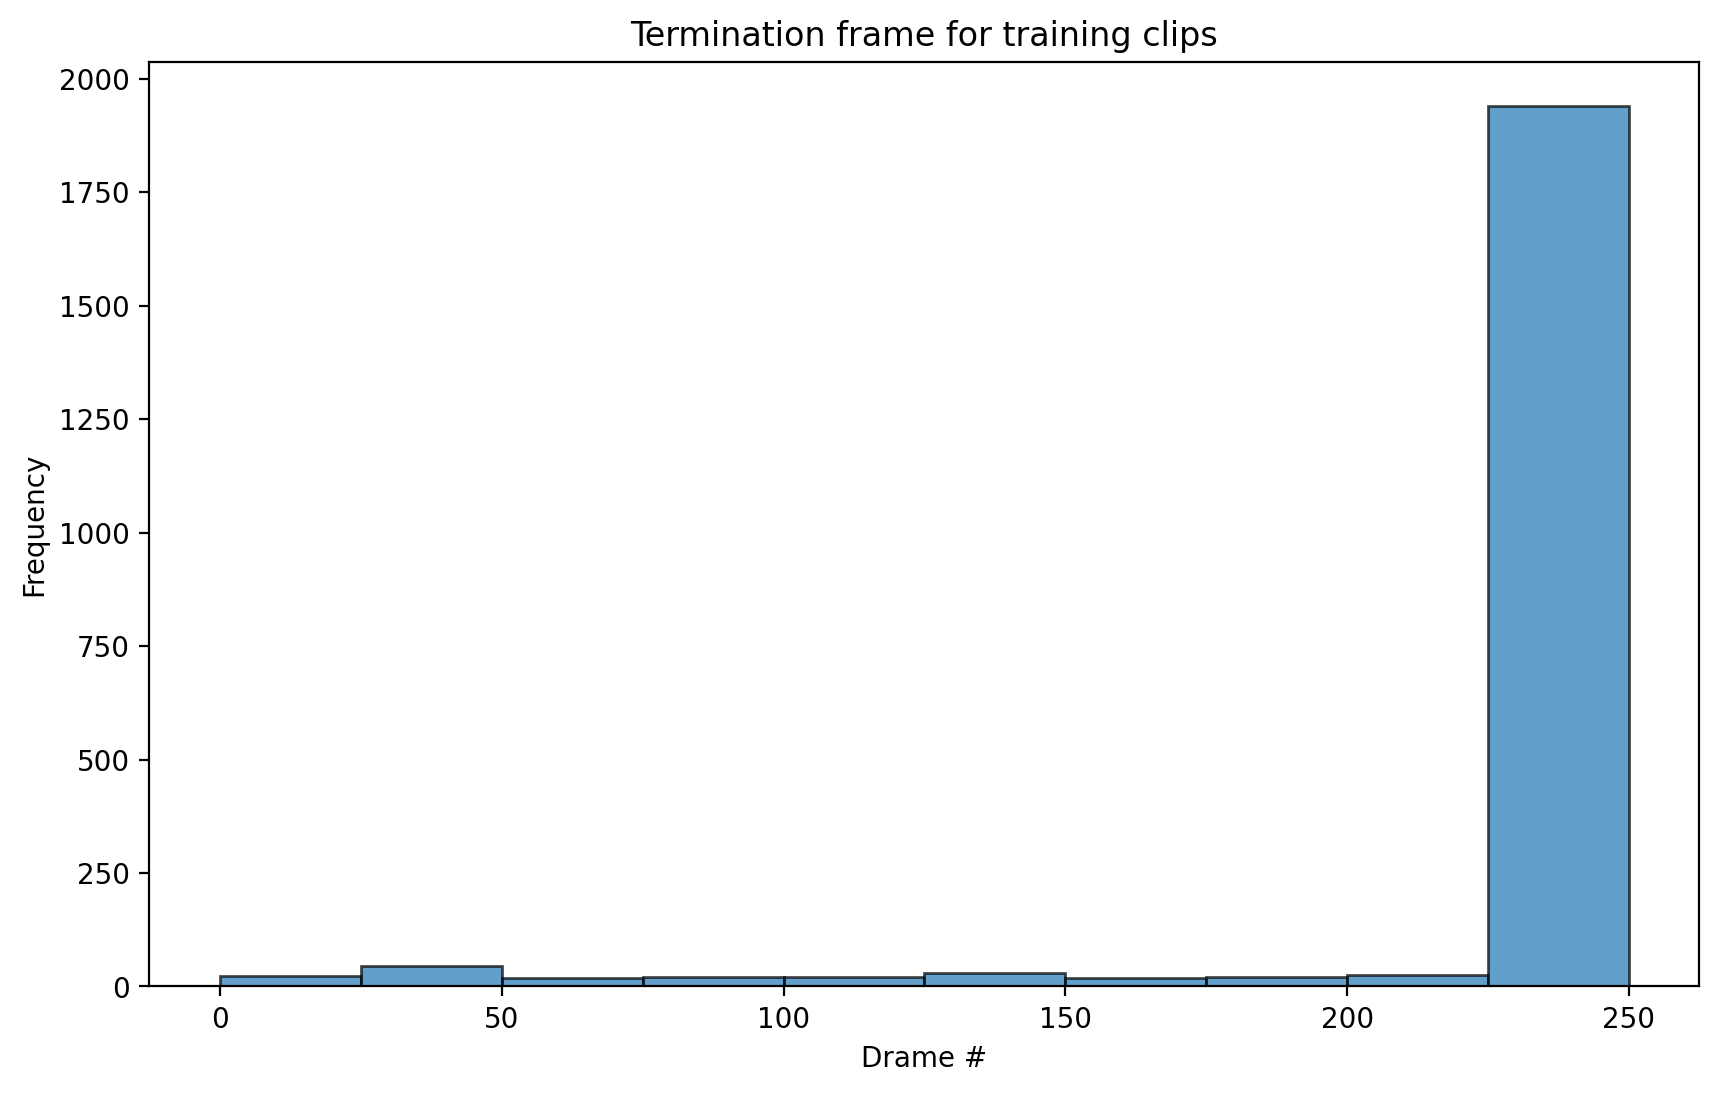

In [36]:
# plot histogram of done times
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.hist(done_steps, bins=np.arange(0, 251, 25), edgecolor='black', alpha=0.7)

# Adding titles and labels
plt.title('Termination frame for training clips')
plt.xlabel('Drame #')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [19]:
import imageio
from IPython.display import Video
import mujoco
from dm_control import mjcf as mjcf_dm
from dm_control.locomotion.walkers import rescale
os.environ["MUJOCO_GL"] = "glfw"

video_path = "random_rollout" + '.mp4'
with imageio.get_writer(video_path, fps=100) as video:
    video = rollout_env.render(rollout, camera=1, height=500, width=500)
    
media.show_video(video, fps=100)

/Users/charleszhang/miniforge3/envs/rl/lib/python3.11/site-packages/imageio_ffmpeg/_utils.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


In [9]:
import cv2
import PIL.Image

qs = [r.q for r in rollout]
rewards = [r.reward for r in states]

In [10]:
states[-1].metrics

{'distance_from_origin': Array(0.02209584, dtype=float32),
 'forward_reward': Array(0.3456622, dtype=float32),
 'reward_alive': Array(1., dtype=float32, weak_type=True),
 'reward_linvel': Array(0.3456622, dtype=float32),
 'reward_quadctrl': Array(-2.6285236, dtype=float32),
 'x_position': Array(0.01933072, dtype=float32),
 'x_velocity': Array(0.03456622, dtype=float32),
 'y_position': Array(-0.01069376, dtype=float32),
 'y_velocity': Array(-0.02182172, dtype=float32)}

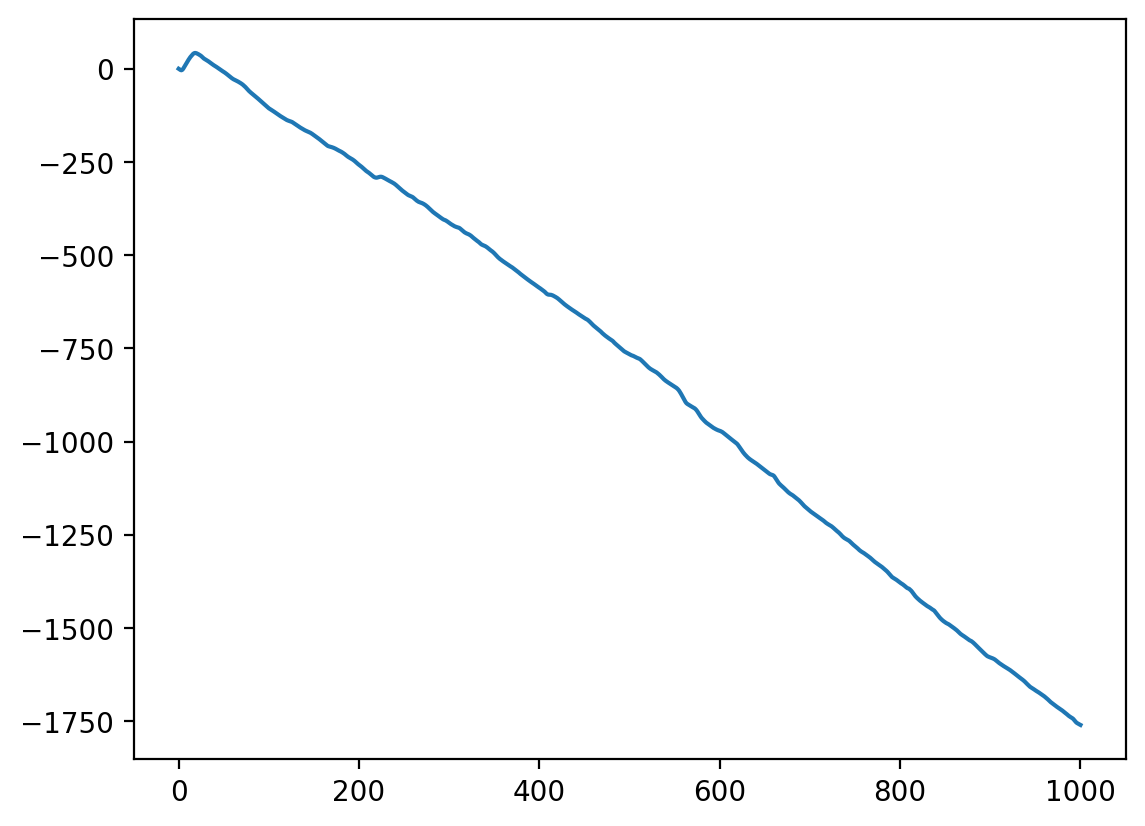

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(np.cumsum(rewards))
plt.show()


In [12]:
len(qs[0])

74

In [13]:
def plot_kinematics(qs, up_to, idx=-1, total_len=2000):
    fig = plt.figure(figsize=(5, 5))
    if idx == -1:
        qs = [r.q for r in rollout[:up_to]]
        for _idx in range(len(qs[0])):
            plt.scatter(up_to, qs[up_to-1][_idx], c="r")
    else:
        # qs = [r.subtree_com[1][idx] for r in rollout[:up_to]]
        qs = [r.q[idx] for r in rollout[:up_to]]
        plt.scatter(up_to, qs[up_to-1], c="r")
        
    _ = plt.plot(qs, alpha=0.8)
    plt.xlim(0, total_len)
    plt.ylim(-0.15, 0.15)
    plt.axvline(x=up_to, c="r")
    
    plt.title(f"r.q[{idx}] Trajectory")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    graph = cv2.resize(graph, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
    return graph


def stack_vids(vids, qs, up_to=500, target_idx=2):
    concat_vids = []
    for idx, frame in tqdm(enumerate(vids[:up_to])):
        plot = plot_kinematics(qs, idx+1, idx=target_idx, total_len=up_to)
        total = np.hstack((frame, plot))
        concat_vids.append(total)
    return concat_vids

In [14]:
import matplotlib
matplotlib.use('svg') 

In [15]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.

videos = stack_vids(video, qs, target_idx=2)

0it [00:00, ?it/s]

500it [00:14, 34.88it/s]


In [16]:
media.show_video(videos, fps=30)

In [17]:
graph.shape

NameError: name 'graph' is not defined

In [ ]:
which = 2
front = 200
qs = [r.q[which] for r in rollout[:front]]
_ = plt.plot(qs, alpha=0.8)
plt.xlim(0, 2000)
plt.axvline(x=front, c="r")
plt.scatter(front, qs[front-1], c="r")
plt.title(f"r.q[{which}] Trajectory")